# Sound Event Classification

## Requirements

In [1]:
from google.colab import files
uploaded = files.upload()

Saving requirements.txt to requirements (1).txt


In [2]:
%pip install -r requirements.txt

## Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
import IPython.display as ipd
import tqdm
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
plt.style.use("seaborn-v0_8")

from audiomentations import AddGaussianSNR, PitchShift, TimeStretch, ApplyImpulseResponse
from pedalboard import Pedalboard, Compressor

import warnings


In [4]:
warnings.filterwarnings('ignore') # run to suppress warnings

## Dataset

In [5]:
!wget https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip
!unzip Audio.zip

--2025-06-10 09:07:23--  https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip
Resolving mcdermottlab.mit.edu (mcdermottlab.mit.edu)... 18.13.53.64
Connecting to mcdermottlab.mit.edu (mcdermottlab.mit.edu)|18.13.53.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11660005 (11M) [application/zip]
Saving to: ‘Audio.zip’

Audio.zip           100%[===================>]  11.12M  13.5MB/s    in 0.8s    

2025-06-10 09:07:24 (13.5 MB/s) - ‘Audio.zip’ saved [11660005/11660005]

Archive:  Audio.zip
   creating: Audio/
  inflating: Audio/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/Audio/
  inflating: __MACOSX/Audio/._.DS_Store  
  inflating: Audio/h001_Bedroom_65txts.wav  
  inflating: Audio/h002_Bedroom_62txts.wav  
  inflating: Audio/h003_Office_LargeBrickWalledOpenPlanOffice_56txts.wav  
  inflating: Audio/h004_LivingRoom_Large_48txts.wav  
  inflating: Audio/h005_Office_Small_44txts.wav  
  inflating: Audio/h006_Bedroom_42txts.wav  
  inflatin

Required [ESC-50 Dataset](https://github.com/karolpiczak/ESC-50/archive/master.zip)

In [6]:
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip master.zip

--2025-06-10 09:07:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-06-10 09:07:30--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [             <=>    ] 615.78M  13.6MB/s    in 40s     

2025-06-10 09:08:10 (15.5 MB/s) - ‘master.zip’ saved [645695005]

Archive:  master.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-

### Loading of the dataset of the metadata and dataset analysis

In [5]:
fn_csv = 'ESC-50-master/meta/esc50.csv'

ds_files = []  # File list
ds_labels = []  # Class list

ds = pd.read_csv(fn_csv)
ds.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
#unique class labels
unique_classes = ds['category'].unique()
print("Unique classes:", unique_classes)

# Check the number of unique class labels
print("Count:", len(unique_classes))

# Filling the lists with filenames and labels
ds_files = ds['filename'].values
pure_ds_labels = ds['category'].values

Unique classes: ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']
Count: 50


# Feature extraction

Nos cargamos todos los signales

In [7]:
pure_signals = []
audio_folder = "ESC-50-master/audio/"

for file in ds_files:
    filepath = os.path.join(audio_folder, file)
    pure_signal, sr = librosa.load(filepath)
    pure_signals.append(pure_signal)

Check pre pre-processing

In [8]:
print(f"Number of audio files: {len(pure_signals)}")
print(f"Number of audio labels: {len(pure_ds_labels)}")

Number of audio files: 2000
Number of audio labels: 2000


Lista -> np

In [9]:
pure_signals_array = np.asarray(pure_signals)

# Transform the labels to numbers
label_mapping = {label: idx for idx, label in enumerate(dict.fromkeys(pure_ds_labels))}
numerical_labels = np.array([label_mapping[label] for label in pure_ds_labels])

Ydata = np.asarray(numerical_labels) # Aquí, hay todas las clases

print('Pure signals length: {} \nYata shape: {}'.format(pure_signals_array.shape, Ydata.shape))

Pure signals length: (2000, 110250) 
Yata shape: (2000,)


### no cross v

In [10]:
seed = 42 # We set a seed for reproducibility

X_train, X_temp, y_train, y_temp = train_test_split(pure_signals_array, Ydata, train_size=0.7, random_state=seed, stratify=Ydata) #we use stratify to keep the same distribution of classes in the training set

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=seed, stratify=y_temp)  #we use stratify to keep the same distribution of classes in the validation and test sets
print('X_train shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))


X_train shape: (1400, 110250) 
X_val shape: (400, 110250) 
X_test shape: (200, 110250) 
y_train shape: (1400,) 
y_val shape: (400,) 
y_test shape: (200,) 



augmentation on train set

feature extraction

In [11]:
def mel_spectrogram_dataset(X, sr, n_mels=128, fmax=8000):
    """
    Computes the mel spectrogram for a dataset of audio signals.
    Args:
        X (np.ndarray): Array of audio signals.
        sr (int): Sample rate of the audio signals.
        n_mels (int): Number of mel bands to generate.
        fmax (int): Maximum frequency to consider in the mel spectrogram.
    Returns:
        np.ndarray: Array of mel spectrograms.
    """

    mel_spectrograms = []
    for signal in X:
        S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        mel_spectrograms.append(S_dB)

    return np.array(mel_spectrograms)

In [12]:
#farei qui feature extraction per il test
X_test_fe = mel_spectrogram_dataset(X_test, sr)
print('X_test_fe shape: {}'.format(X_test_fe.shape))

X_train_fe = mel_spectrogram_dataset(X_train, sr)
print('X_train_fe shape: {}'.format(X_train_fe.shape))

X_val_fe = mel_spectrogram_dataset(X_val, sr)
print('X_val_fe shape: {}'.format(X_val_fe.shape))

X_test_fe shape: (200, 128, 216)
X_train_fe shape: (1400, 128, 216)
X_val_fe shape: (400, 128, 216)


In [13]:
X_train_exp = np.expand_dims(X_train_fe, axis=-1)
print('X_test_exp shape: {}'.format(X_train_exp.shape))

X_test_exp = np.expand_dims(X_test_fe, axis=-1)
print('X_test_exp shape: {}'.format(X_test_exp.shape))

X_val_exp = np.expand_dims(X_val_fe, axis=-1)
print('X_test_exp shape: {}'.format(X_val_exp.shape))

X_test_exp shape: (1400, 128, 216, 1)
X_test_exp shape: (200, 128, 216, 1)
X_test_exp shape: (400, 128, 216, 1)


# model4jose

In [14]:
input_shape = X_train_exp.shape[1:]
print('INPUT SHAPE:',input_shape)

model_2D=tf.keras.models.Sequential()
model_2D.add(tf.keras.Input(shape=input_shape))

#1st Conv 2D layer
model_2D.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name='CONV1'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP1'))
model_2D.add(tf.keras.layers.BatchNormalization())

#2nd Conv layer
model_2D.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name='CONV2'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP2'))
model_2D.add(tf.keras.layers.BatchNormalization())

#3rd Conv layer
model_2D.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name='CONV3'))
model_2D.add(tf.keras.layers.MaxPooling2D((2,2), padding='same', name='MP3'))
model_2D.add(tf.keras.layers.BatchNormalization())
model_2D.add(tf.keras.layers.Flatten(name='FLATTEN'))

#4th Dense Layer
model_2D.add(tf.keras.layers.Dense(32, activation='relu', name='DENSE'))

#output layer
model_2D.add(tf.keras.layers.Dense(50, activation='softmax', name='SOFTMAX'))
model_2D.summary()

INPUT SHAPE: (128, 216, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CONV1 (Conv2D)                  │ (None, 128, 216, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP1 (MaxPooling2D)              │ (None, 64, 108, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 108, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV2 (Conv2D)                  │ (None, 64, 108, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP2 (MaxPooling2D)              │ (None, 32, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 54, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV3 (Conv2D)                  │ (None, 32, 54, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MP3 (MaxPooling2D)              │ (None, 16, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FLATTEN (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DENSE (Dense)                   │ (None, 32)             │       442,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SOFTMAX (Dense)                 │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 451,426 (1.72 MB)

 Trainable params: 451,298 (1.72 MB)

 Non-trainable params: 128 (512.00 B)

In [15]:
# CSVLogger
csv_logger = CSVLogger('training_2D_CNN.log', append=False)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#model checkpoint
model_name = 'CNN_2D_model.h5'
model_checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, verbose=1)

#store all these callbacks in a list, Callback list
callbacks = [csv_logger, early_stopping, model_checkpoint]

# Compile the model
learning_rate=0.001
batch_size=32
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_2D.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history_2D = model_2D.fit(X_train_exp, y_train, batch_size=batch_size, epochs=300, validation_data=(X_val_exp, y_val), callbacks=callbacks)

Epoch 1/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0544 - loss: 4.1491
Epoch 1: val_accuracy improved from -inf to 0.02000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.0544 - loss: 4.1455 - val_accuracy: 0.0200 - val_loss: 3.9883
Epoch 2/300
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0788 - loss: 3.7070
Epoch 2: val_accuracy improved from 0.02000 to 0.04500, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0807 - loss: 3.7015 - val_accuracy: 0.0450 - val_loss: 3.8345
Epoch 3/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1593 - loss: 3.2801
Epoch 3: val_accuracy improved from 0.04500 to 0.11000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1612 - loss: 3.2762 - val_accuracy: 0.1100 - val_loss: 3.5458
Epoch 4/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2568 - loss: 2.8501
Epoch 4: val_accuracy improved from 0.11000 to 0.13000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2575 - loss: 2.8512 - val_accuracy: 0.1300 - val_loss: 3.5997
Epoch 5/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3428 - loss: 2.5507
Epoch 5: val_accuracy improved from 0.13000 to 0.22250, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3451 - loss: 2.5418 - val_accuracy: 0.2225 - val_loss: 3.2542
Epoch 6/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4583 - loss: 1.9416
Epoch 6: val_accuracy improved from 0.22250 to 0.28750, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4605 - loss: 1.9393 - val_accuracy: 0.2875 - val_loss: 2.9499
Epoch 7/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6106 - loss: 1.4153
Epoch 7: val_accuracy did not improve from 0.28750
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6091 - loss: 1.4156 - val_accuracy: 0.2225 - val_loss: 3.1177
Epoch 8/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7393 - loss: 0.9765
Epoch 8: val_accuracy improved from 0.28750 to 0.31000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7393 - loss: 0.9751 - val_accuracy: 0.3100 - val_loss: 2.9742
Epoch 9/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8535 - loss: 0.5384
Epoch 9: val_accuracy improved from 0.31000 to 0.32750, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8515 - loss: 0.5435 - val_accuracy: 0.3275 - val_loss: 2.9164
Epoch 10/300
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8903 - loss: 0.3919
Epoch 10: val_accuracy improved from 0.32750 to 0.35250, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8909 - loss: 0.3903 - val_accuracy: 0.3525 - val_loss: 2.9029
Epoch 11/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9583 - loss: 0.1825
Epoch 11: val_accuracy did not improve from 0.35250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9583 - loss: 0.1823 - val_accuracy: 0.3450 - val_loss: 3.1174
Epoch 12/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9859 - loss: 0.0898
Epoch 12: val_accuracy improved from 0.35250 to 0.35750, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9858 - loss: 0.0904 - val_accuracy: 0.3575 - val_loss: 3.2076
Epoch 13/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9928 - loss: 0.0613
Epoch 13: val_accuracy improved from 0.35750 to 0.39500, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9928 - loss: 0.0611 - val_accuracy: 0.3950 - val_loss: 3.1002
Epoch 14/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9988 - loss: 0.0320
Epoch 14: val_accuracy did not improve from 0.39500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9987 - loss: 0.0321 - val_accuracy: 0.3750 - val_loss: 3.3743
Epoch 15/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9931 - loss: 0.0405
Epoch 15: val_accuracy did not improve from 0.39500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9934 - loss: 0.0400 - val_accuracy: 0.3600 - val_loss: 3.4001
Epoch 16/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9991 - loss: 0.0178
Epoch 16: val_accuracy did not improve from 0.39500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9991 - loss: 0.0177 - val_accuracy: 0.3650 - val_loss: 3.2700
Epoch 17/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9999 - loss: 0.0102
Epoch 17: val_accuracy improved 

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9998 - loss: 0.0103 - val_accuracy: 0.3975 - val_loss: 3.2394
Epoch 18/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9999 - loss: 0.0083
Epoch 18: val_accuracy did not improve from 0.39750
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9999 - loss: 0.0084 - val_accuracy: 0.3925 - val_loss: 3.3033
Epoch 19/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9998 - loss: 0.0073
Epoch 19: val_accuracy improved from 0.39750 to 0.40500, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9998 - loss: 0.0074 - val_accuracy: 0.4050 - val_loss: 3.2789
Epoch 20/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9987 - loss: 0.0076
Epoch 20: val_accuracy did not improve from 0.40500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9987 - loss: 0.0075 - val_accuracy: 0.4025 - val_loss: 3.3013
Epoch 21/300
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9993 - loss: 0.0057
Epoch 21: val_accuracy did not improve from 0.40500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9993 - loss: 0.0057 - val_accuracy: 0.4025 - val_loss: 3.3400
Epoch 22/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 22: val_accuracy did not improve from 0.40500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.4025 - val_loss: 3.3568
Epoch 23/300
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 23: val_accuracy did not i

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.4100 - val_loss: 3.4116
Epoch 25/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 25: val_accuracy did not improve from 0.41000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.4000 - val_loss: 3.4454
Epoch 26/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 26: val_accuracy improved from 0.41000 to 0.42000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.4200 - val_loss: 3.4053
Epoch 27/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 27: val_accuracy did not improve from 0.42000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.4150 - val_loss: 3.4013
Epoch 28/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 28: val_accuracy did not improve from 0.42000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.4200 - val_loss: 3.4131
Epoch 29/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 29: val_accuracy did not improve from 0.42000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.4125 - val_loss: 3.4047
Epoch 30/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 30: val_accuracy did not i

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 4.8508e-04 - val_accuracy: 0.4225 - val_loss: 3.5689
Epoch 54/300
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.6034e-04
Epoch 54: val_accuracy did not improve from 0.42250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.5867e-04 - val_accuracy: 0.4150 - val_loss: 3.5756
Epoch 55/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.6937e-04
Epoch 55: val_accuracy did not improve from 0.42250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.6991e-04 - val_accuracy: 0.4200 - val_loss: 3.5932
Epoch 56/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.6997e-04
Epoch 56: val_accuracy did not improve from 0.42250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 3.7301e-04 - val_accuracy: 0.4150 - val_loss: 3.5984
Epoch 57/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.5162e-04


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.9774e-04 - val_accuracy: 0.4250 - val_loss: 3.6255
Epoch 69/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.2965e-04
Epoch 69: val_accuracy did not improve from 0.42500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.3203e-04 - val_accuracy: 0.4200 - val_loss: 3.6325
Epoch 70/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.0882e-04
Epoch 70: val_accuracy improved from 0.42500 to 0.43000, saving model to CNN_2D_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.1034e-04 - val_accuracy: 0.4300 - val_loss: 3.6325
Epoch 71/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.0946e-04
Epoch 71: val_accuracy did not improve from 0.43000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.0897e-04 - val_accuracy: 0.4200 - val_loss: 3.6342
Epoch 72/300
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.9364e-04
Epoch 72: val_accuracy did not improve from 0.43000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.9294e-04 - val_accuracy: 0.4275 - val_loss: 3.6411
Epoch 73/300
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6531e-04
Epoch 73: val_accuracy did not improve from 0.43000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.6608e-04 - val_accuracy: 0.4200 - val_loss: 3.6423
Epoch 74/300
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.4268e-04


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.5884e-04 - val_accuracy: 0.4325 - val_loss: 3.6631
Epoch 76/300
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.7752e-04
Epoch 76: val_accuracy did not improve from 0.43250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.7758e-04 - val_accuracy: 0.4225 - val_loss: 3.6555
Epoch 77/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.8388e-04
Epoch 77: val_accuracy did not improve from 0.43250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.8179e-04 - val_accuracy: 0.4250 - val_loss: 3.6632
Epoch 78/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9885 - loss: 0.0442
Epoch 78: val_accuracy did not improve from 0.43250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9816 - loss: 0.0736 - val_accuracy: 0.1925 - val_loss: 10.1447
Epoch 79/300
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5066 - loss: 2.3631
Epoch 79: v

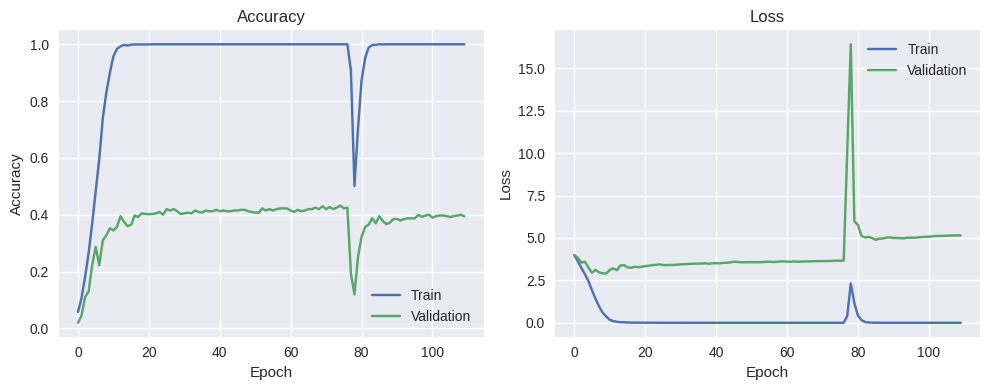

Best validation accuracy:  0.4325000047683716
Epoch for which we get the best validation accuracy:  74
Test loss: 3.1222493648529053
Test accuracy: 0.5299999713897705
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


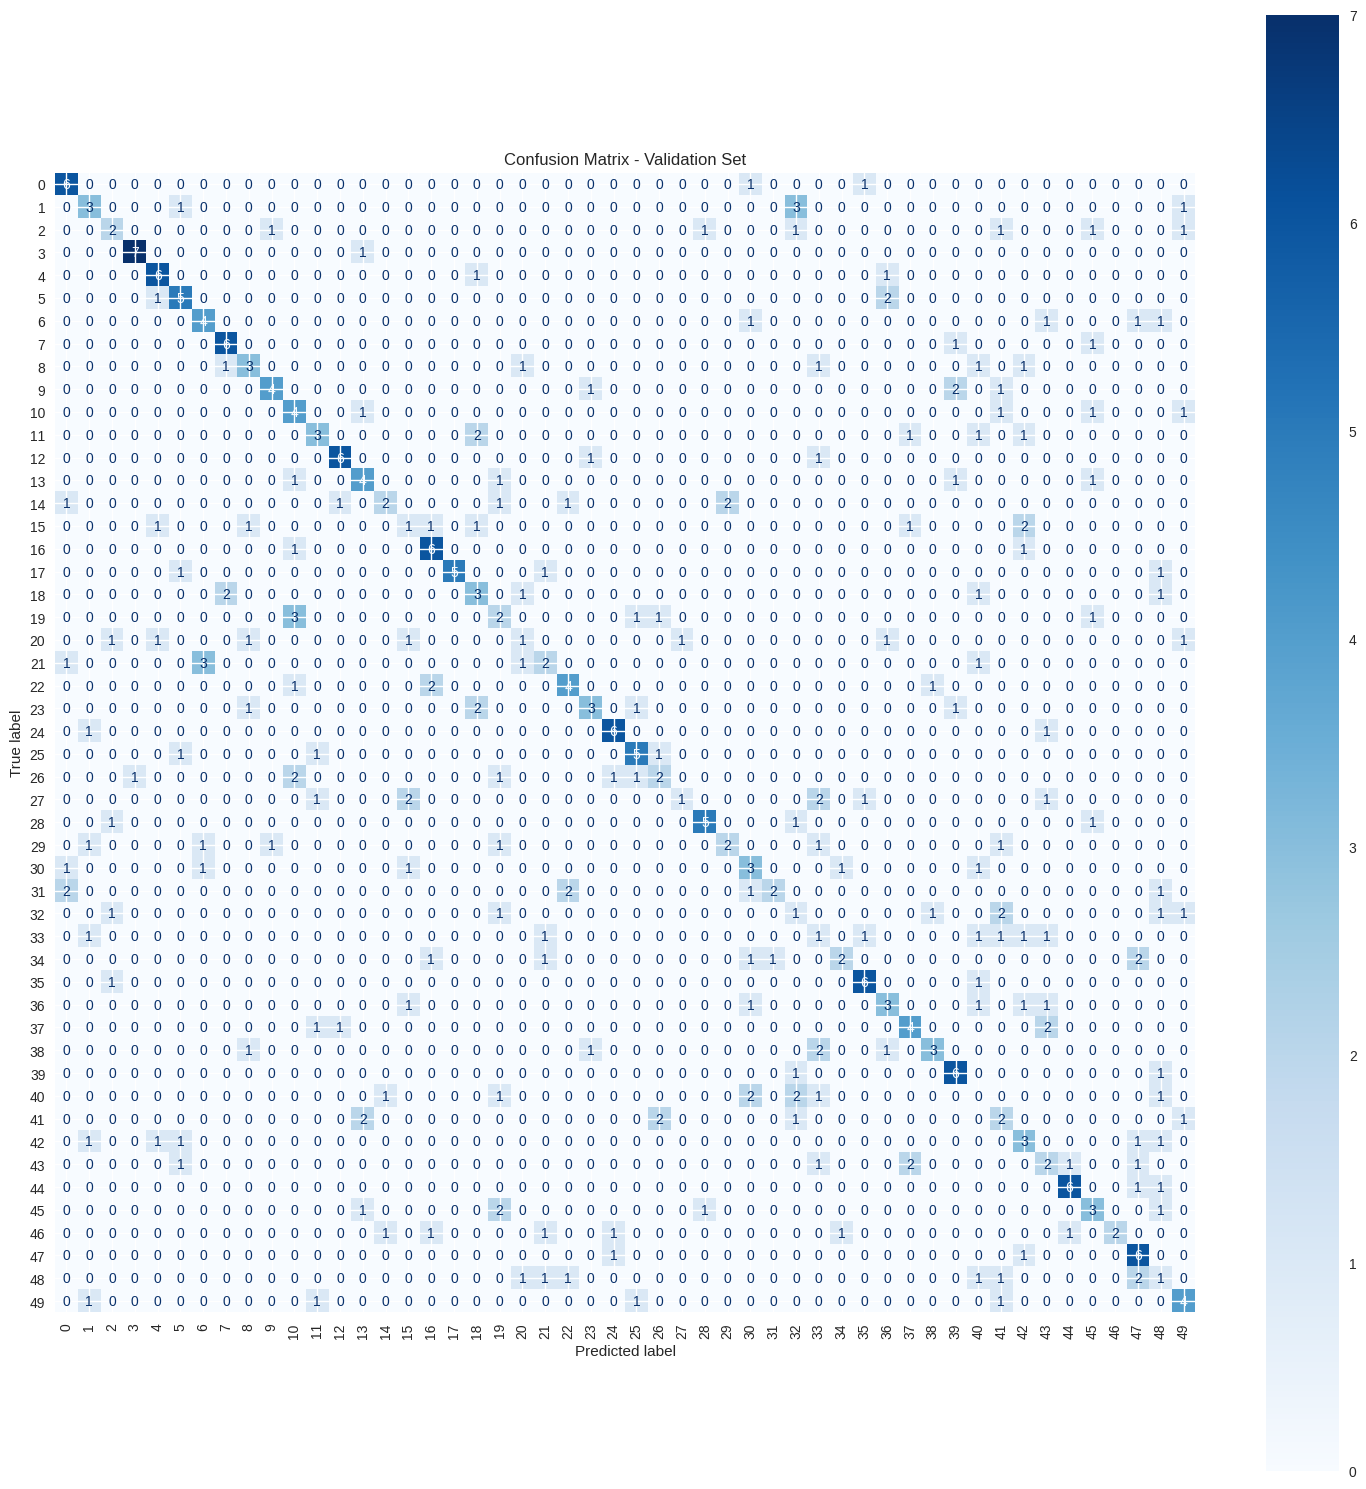

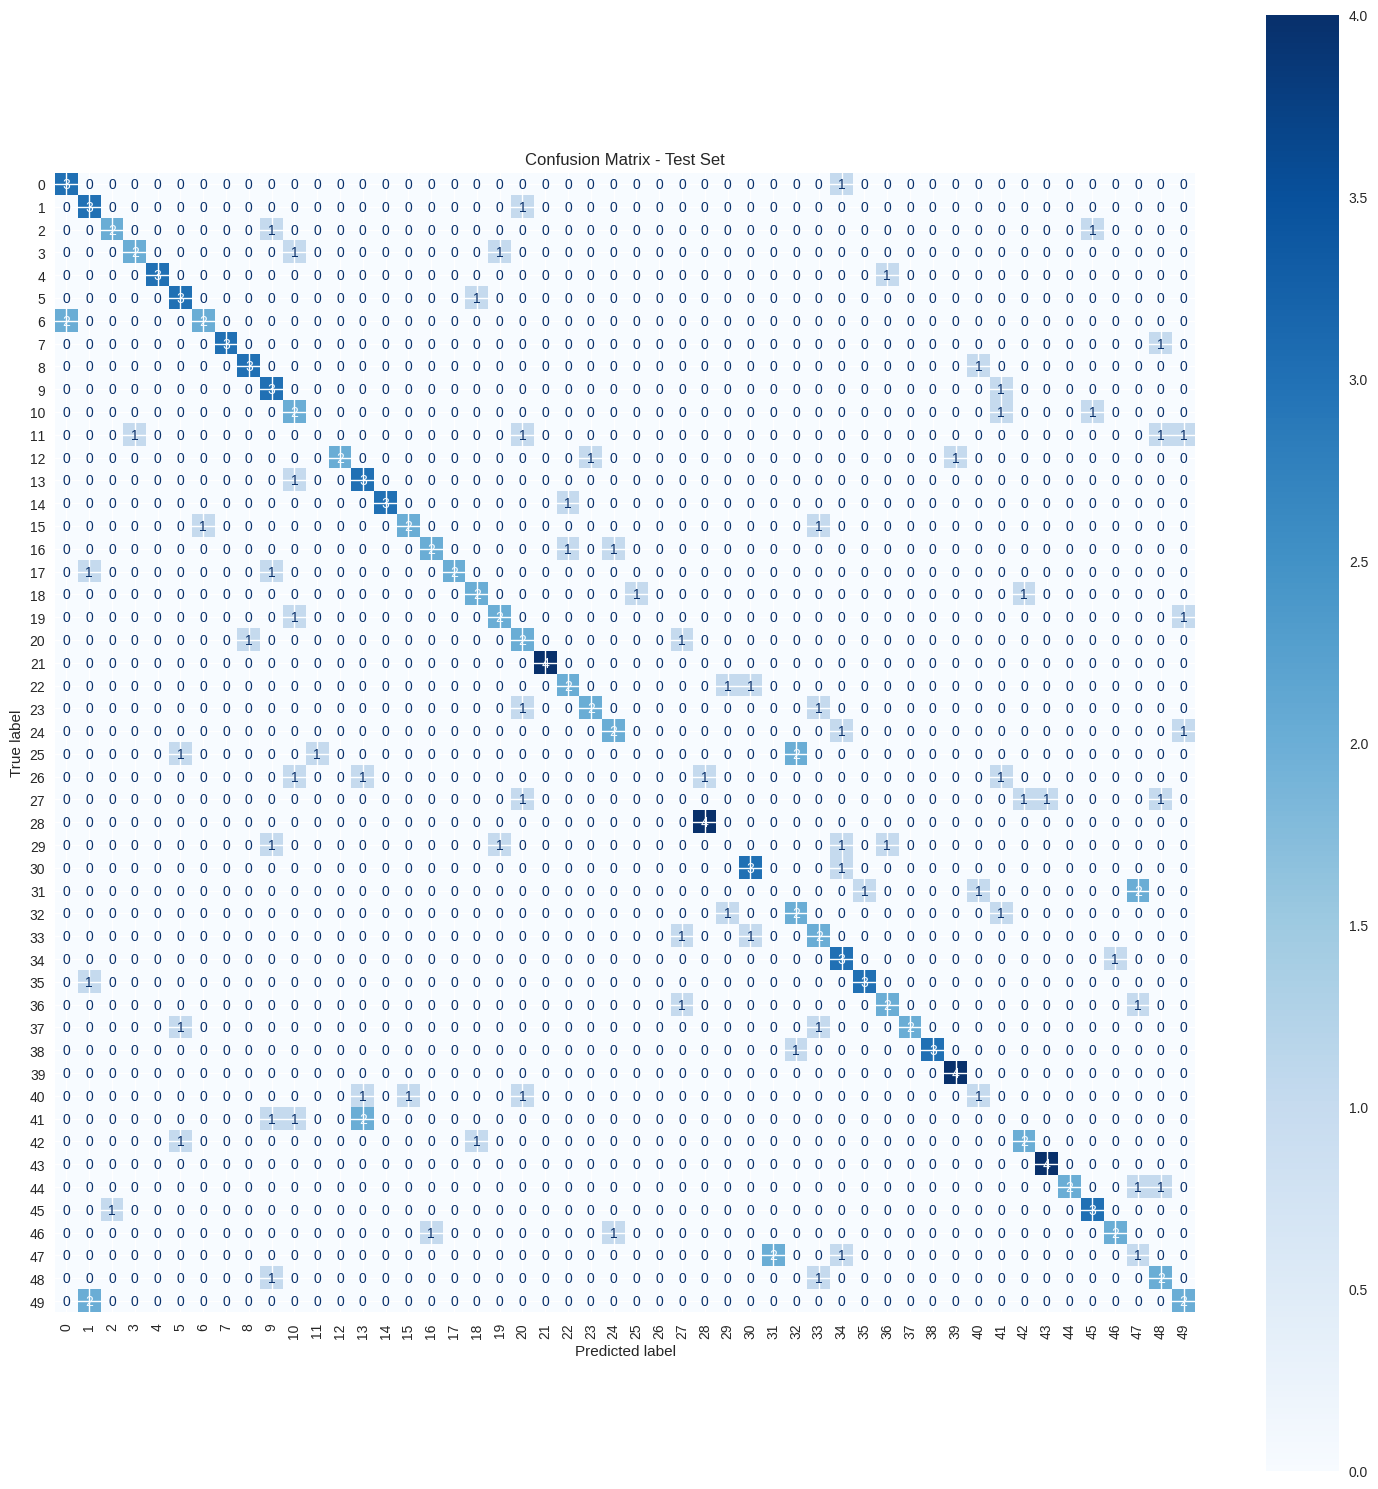

In [17]:
log_df_2D = pd.read_csv('training_2D_CNN.log')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df_2D['epoch'], log_df_2D['accuracy'], label='Train')
plt.plot(log_df_2D['epoch'], log_df_2D['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_df_2D['epoch'], log_df_2D['loss'], label='Train')
plt.plot(log_df_2D['epoch'], log_df_2D['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#best validation accuracy
best_acc = np.max(history_2D.history['val_accuracy'])
best_acc_epoch = np.argmax(history_2D.history['val_accuracy'])
print('Best validation accuracy: ', best_acc)
print('Epoch for which we get the best validation accuracy: ', best_acc_epoch)

model_2D.load_weights('CNN_2D_model.h5')
[loss_test, acc_test] = model_2D.evaluate(X_test_exp, y_test, verbose=0)
print(f"Test loss: {loss_test}")
print(f"Test accuracy: {acc_test}")

possible_classes = np.arange(0, 50)

pred_val = model_2D.predict(X_val_exp)
pred_test = model_2D.predict(X_test_exp)

pred_val_classes = np.argmax(pred_val, axis=1)
pred_test_classes = np.argmax(pred_test, axis=1)

# Confusion matrix computation
cm_val = confusion_matrix(y_val, pred_val_classes)
cm_test = confusion_matrix(y_test, pred_test_classes)

# Confusion Matrix - Validation
fig_val, ax_val = plt.subplots(figsize=(15, 15))
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=possible_classes)
disp_val.plot(cmap=plt.cm.Blues, ax=ax_val, xticks_rotation=90)
ax_val.set_title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.show()

# Confusion Matrix - Test
fig_test, ax_test = plt.subplots(figsize=(15, 15))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=possible_classes)
disp_test.plot(cmap=plt.cm.Blues, ax=ax_test, xticks_rotation=90)
ax_test.set_title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [18]:
print('------------ Validation set --------------')
print(classification_report(y_val, pred_val_classes))

print('---------------- Test set ------------------')
print(classification_report(y_test, pred_test_classes))

------------ Validation set --------------
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.38      0.38      0.38         8
           2       0.33      0.25      0.29         8
           3       0.88      0.88      0.88         8
           4       0.60      0.75      0.67         8
           5       0.50      0.62      0.56         8
           6       0.44      0.50      0.47         8
           7       0.67      0.75      0.71         8
           8       0.43      0.38      0.40         8
           9       0.67      0.50      0.57         8
          10       0.33      0.50      0.40         8
          11       0.43      0.38      0.40         8
          12       0.75      0.75      0.75         8
          13       0.44      0.50      0.47         8
          14       0.50      0.25      0.33         8
          15       0.17      0.12      0.14         8
          16       0.55      0.75     